In [9]:
import numpy
from numpy.random import rand
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})
from scipy.integrate import quad
import unittest

# 02 Testing Scientific Codes

# Why do we test?
- In the experimental Sciences, new theories are developed by applying the Scientific method
- Perform tests to demonstrate results are ***accurate, reproducible*** and ***reliable***
- Test experimental setup show it's working as designed and to eliminate or quantify any systematic errors
- A result will not be trusted unless experiment itself has been carried out to a suitable standard

# Why do we test?
- In computational Science, we should apply the same principles to our code
- A result should only be trusted if the code that has produced it has undergone rigorous testing which demonstrates:
    * it is working as intended 
    * any limitations of the code (e.g. numerical errors) are understood and quantified

# Testing scientific code is hard
- Often investigate systems where *exact behaviour unknown*
- Can be very *complex*, built over a number of years (or even decades!) with contributions from a vast number of people
- Even for the most complicated of codes there are a number of different tests we can apply to build ***robust, reliable code*** whose results can be ***trusted***. 

<center>![Good code](https://imgs.xkcd.com/comics/good_code.png )
[xkcd](https://xkcd.com/844/)</center>

# When should I test?
<br />
## Always and often

- The earlier you start testing the better:
    * catch bugs as they develop and before they become too entrenched in the code. 
- Try and execute tests every time changes are made
- Continuous integration useful to make sure tests are run frequently 

# When should I test?
- Important to ***review your tests regularly***
- In actively developed code, tests must be amended and new tests written so new features are also tested
- Regression tests useful to test changes to the code improve its performance rather than making it worse
- Code coverage makes sure ***all*** code is being tested
    * If only 20% of the code has been tested, cannot trust other 80% of the code is producing reliable results 

# Effective testing

- Necessary to make sure entire parameter space is tested, not just one or two nice cases
- Particularly important: *edge* and *corner* cases
    * Edge cases: at beginning and end of input parameter space
    * Corner cases: one or more edge cases are combined
- Errors frequently arise here - often special code is required to deal with boundary values

In the code below, we demonstrate the importance of testing edge cases. The code takes a vector $\mathbf{v}$ and normalises it $\hat{\mathbf{v}} = \frac{\mathbf{v} }{ |\mathbf{v}|}$. We see that if the code is run for the vector $(0,0)$, a `RuntimeWarning` is raised as the function is attempting to divide by zero. 

In [ ]:
def normalise(v):
    norm = numpy.sqrt(numpy.sum(v**2))
    
    return v / norm

normalise(numpy.array([0,0]))

We therefore need to amend our function for the case where the norm of the vector is zero. A possible solution is the function below.

In [ ]:
def improved_normalise(v):
    norm = numpy.sqrt(numpy.sum(v**2))
    
    if norm == 0.:
        return v
    
    return v / norm

improved_normalise(numpy.array([0,0]))

Our improved function now tests to see if the norm is zero - if so, it returns the original vector rather than attempting to divide by zero. 

# Tests should break your code
- Also important to check code breaks as expected
- If code input is garbage but still manages to run as normal, that is not good behaviour and suggests some validation of inputs is needed
- Highlights where runtime testing and exceptions are needed in code

In [ ]:
improved_normalise("I am a string")

Python correctly spots that it cannot perform the power operation on a string and raises a `TypeError` exception. However, it would probably be more useful to implement some kind of type checking of the function inputs before this (e.g. using `numpy.isnumeric`), and/or make sure that the code that calls this function is capable of catching such exceptions.

# Unit tests

- For complicated codes made up of many functions, useful to write tests that check small parts - *units* - at a time
- Easier to track down exact location of bugs
- Units may be individual functions or groups of shorter functions
- Encourage good coding practice as require code to be modular

In the example below, we have three (very simple) functions: `squared` which returns the square of its input, `add_2` which adds 2 to its input and `square_plus_2` which calls the two previous functions to return $x^2+2$. To test this code, we could therefore write unit tests for the first two functions to check they are working correctly. We've used the `unittest` module here as it allows us to test that functions correctly raise exceptions when given invalid data.

In [ ]:
def squared(x):
    return x*x

def add_2(x):
    return x + 2

def square_plus_2(x):
    return add_2(squared(x))

class test_units(unittest.TestCase):
    
    def test_squared(self):
        self.assertTrue(squared(-5) == 25)
        self.assertTrue(squared(1e5) == 1e10)
        self.assertRaises(TypeError, squared, "A string")
        
    def test_add_2(self):
        self.assertTrue(add_2(-5) == -3)
        self.assertTrue(add_2(1e5) == 100002)
        self.assertRaises(TypeError, add_2, "A string")
    
test_units().test_squared()
test_units().test_add_2()

# Integration tests

- Need to verify smaller units work together.
- Individual functions may work, but this is no guarantee that they will work when put together
- Can encompass a small section of code, e.g. to check that one function correctly calls another, all the way up to the entire code
- Integration tests can be difficult to design - can involve many different functions, so often a lot more complex than unit tests

In the above example, we can add an integration test by writing a test for `square_plus_2` - this calls the other two functions, so we'll test that it does this properly.

In [11]:
class test_integration(unittest.TestCase):
    
    def test_square_plus_2(self):
        self.assertTrue(square_plus_2(-5) == 27)
        self.assertTrue(square_plus_2(1e5) == 10000000002)
        self.assertRaises(TypeError, square_plus_2, "A string")
        
test_integration().test_square_plus_2()

# Convergence tests

- Often calculate solution on some grid - a discretised approximation of exact continuous solution
- As grid resolution increases, solution should approach exact solution
- *Convergence tests* check this
- Calculate solution at various resolutions, calculate error
- Error should decrease with increasing resolution at algorithm's order of convergence

In the example below, we will demonstrate this by using the trapezium rule to approximate the integral of $\sin (x)$ with various different step sizes, $h$. By comparing the calculated errors to a line of gradient $h^2$, it can be seen that the numerical approximation is converging as expected at $O(h^2)$.

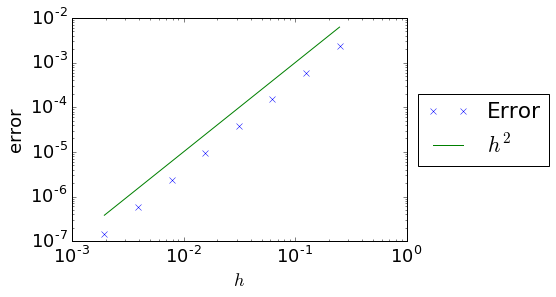

In [21]:
hs = numpy.array([1. / (4. * 2.**n) for n in range(8)])
errors = numpy.zeros_like(hs)

for i, h in enumerate(hs):
    xs = numpy.arange(0., 1.+h, h)
    ys = numpy.sin(xs)
    
    # use trapezium rule to approximate integral
    integral_approx = sum((xs[1:] - xs[:-1]) * 0.5 * (ys[1:] + ys[:-1]))
    errors[i] = -numpy.cos(1) + numpy.cos(0) - integral_approx
    
plt.loglog(hs, errors, 'x', label='Error')
plt.plot(hs, 0.1*hs**2, label=r'$h^2$')
plt.xlabel(r'$h$'); plt.ylabel('error'); plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5]); plt.show()

# Regression tests

- When building your code, generally aim for its performance to improve with time
- Results should get more accurate (or at least not deteriorate)
- Solution: *regression tests* 
- Run multiple versions of code, compare outputs
- If output has changed, test fails
- Helps catch bugs other types of tests may not, ensure project remains backwards-compatible

# Common problems and how to solve them

# My code has some randomness
- Time evolution problems: output at individual timestep may be random, but behaviour averaged over several timesteps is known - test this!
- Other problems: test average behaviour across entire domain or sections of domain
- Even if completely random so not possible to take meaninful averages, outputs should still be within set of known values - test this!
- Write tests that isolate random parts so can check non-random parts work
- If using a random number generator, eliminate non-determinism by testing using a fixed seed value

In the code below, we generate an array of random data and apply some function to it before plotting the results. It can be seen that the output is different every time the code is run.

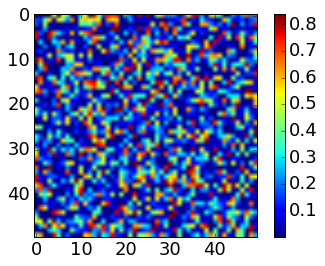

In [14]:
data = rand(50,50)

def func(a):
    return a**2 * numpy.sin(a)

output = func(data)

plt.imshow(output)
plt.colorbar()
plt.show()

The output of this code changes every time the code is run, however we can still write some tests for it. We know that all values in the output array must be $0\leq x \leq 1$. In some circumstances, such as in this case, we may know the statistical distribution of the random data. We can therefore calculate what the average output value should be and compare this to our code's output. In our case, the data is generated from a uniform distribution of numbers between 0 and 1, so the average value of the output is given by $\int_0^1 f(x) dx \simeq 0.22$

In [ ]:
def test_limits(a):
    if numpy.all(a >= 0.) and numpy.all(a <= 1.):
        return True
    return False

def test_average(a):
    if numpy.isclose(numpy.average(a), 0.22, rtol=5.e-2):
        return True
    return False

if test_limits(output):
    print('Function output within correct limits')
else:
    print('Function output is not within correct limits')

if test_average(output):
    print('Function output has correct average')
else:
    print('Function output does not have correct average')

# I don't know the correct solution

- In experimental science, test experimental setup using a *control*
    * Use input data where outcome is known so any bugs in apparatus or systematic errors can be identified and understood
- In computational science, there's usually a simple system whose behaviour is known
    * Time evolution problems: system which is initially static should remain that way
- If this is not the case, there is something seriously wrong with the code! 
- In physics, can check for symmetries (e.g. translation, reflection, time reversal), conserved quantities (e.g. mass, energy, charge)

In the below example, we look at a black box function - `scipy.integrate.quad`. Here, this function will stand in for a bit of code that we have written and want to test. Say we wish to use `quad` to calculate the integral of some complicated function and we have little idea what the solution will be. Before we use it on the complicated function, we will test that it behaves correctly for a function whose integral we already know: $f(x) = \sin(x)$.

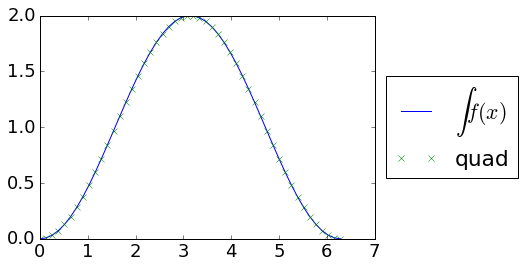

In [15]:
xs = numpy.linspace(0.0, 2.0 * numpy.pi)

integrals = numpy.zeros_like(xs) 

for i in range(len(xs)):
    integrals[i] = quad(numpy.sin, 0.0, xs[i])[0]

plt.plot(xs, -numpy.cos(xs)+1, '-', label=r'$\int f(x)$')
plt.plot(xs, integrals, 'x', label='quad')
plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.show()

As hoped, quad gives the correct solution: 

$$
\int^\alpha_0 \sin(x)\, dx = -\cos(\alpha) + 1
$$

# I didn't write most of the code - how do I know that the bit I wrote works?

- Unit tests! 
- Test original code in isolation
- Any failures in subsequent tests that then incorporate your code will therefore only be the result of bugs in your code

# I know there is some numerical error in my code - how can I test my code is correct up to this error?

- In numerical calculations, there will always be some computational error that cannot be avoided
    * floating point representation of numerical data 
    * accuracy  of algorithm
- Rarely require result to be 100% precise, but instead correct up to some tolerance
- Build tests to reflect this. 

In python, we can use `numpy.isclose` and `numpy.allclose` to do this. In the example below, we take some data and add a small amount of random noise to it. This random noise is supposed to represent numerical errors that are introduced over the course of a simulation. If we test that the output array is equal to the original array, python correctly tells us that it is not. However, if we test that the output array is close to the original array, we find that this is true.

Noisey data is not exactly equal to initial data
Noisey data is close to initial data


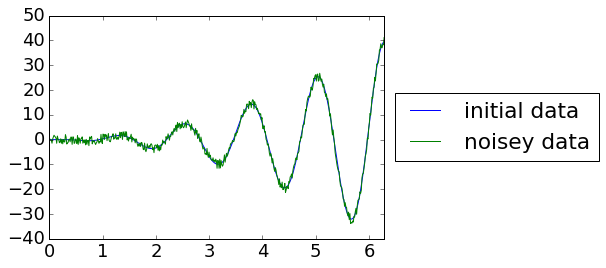

In [20]:
x = numpy.linspace(0, 2*numpy.pi, num=500); initial_data = x**2 * numpy.cos(5*x)
noisey_data = initial_data + (rand(len(x)) - 0.5) * 4 # add noise 

plt.plot(x, initial_data, label='initial data'); plt.plot(x, noisey_data, label='noisey data')
plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5]); plt.xlim(x[0], x[-1])

if numpy.array_equal(initial_data, noisey_data):
    print('Noisey data exactly equal to initial data')
else:
    print('Noisey data is not exactly equal to initial data')    
if numpy.allclose(initial_data, noisey_data, atol=2):
    print('Noisey data is close to initial data')
else:
    print('Noisey data is not close to initial data')
plt.show()

## Further reading

### Coverage

As mentioned above, if our tests only cover a small fraction of our code, then we still cannot trust our code's output. Fortunately, there are tools out there that make the job of analysing test coverage easier. In python, we can use the `coverage` module, for C/C++ there is `gcov`, and for C/C++/fortran `tcov` can be used. Tools like [Codecov](https://codecov.io/) can be used to integrate these tools with continuous integration, providing an easy-to-use interface to analyse code coverage and keep track of code coverage as code is developed. These tools are also particularly useful if code is written in multiple languages, as they will combine reports produced for each of the different languages.

### Continuous integration

So you've written a set of tests for your code, you run them and everything passes - great! However, you then go back to work on your code and quickly forget about testing it. Eventually, a few months later after implementing several new features, you remember to try testing your code again. You run the set of tests, only to find that they fail. 

This unfortunate experience could have been prevented if you'd been using continuous integration from the start. This will run your tests for you regularly (e.g. every night, every time you push changes to a repository) and report back to you the results. This means that you can now spot (almost) instantly when a change is implemented that causes the code to break. Bugs can therefore be fixed before they become too entrenched in the code.

#### How?
* There are several tools out there for doing continuous integration, e.g. [`travis.ci`](https://travis-ci.org/), [`jenkins`](https://jenkins.io/), [`CircleCi`](https://circleci.com/)
* Involve writing a short script which details the computational setup (i.e. any libraries needed) and what code should be run to execute tests

<img src="continuous_integration.jpg" width=40% alt="Continuous integration">
<center>[Geek and poke](http://geekandpoke.typepad.com/geekandpoke/2010/10/geekpokes-list-of-best-practices-today-continuous-integration.html)</center>